# Instacart Orders

---


**Author:** Dr. John Montalbo

## Overview

In this notebook, we explore an Instacart dataset to uncover key insights and better understand customer purchasing behavior.

## Data Overview

The dataset includes multiple `.csv` files, each contributing to the overall structure. Below is a summary of the files and their contents:

- **aisles.csv**  
  *Columns:* `[aisle_id, aisle]`  
  Maps aisle IDs to their corresponding aisle names.

- **departments.csv**  
  *Columns:* `[department_id, department]`  
  Maps department IDs to department names.

- **order_products__prior.csv**  
  *Columns:* `[order_id, product_id, add_to_cart_order, reordered]`  
  Links each product to an order (like a receipt number).  
  - `add_to_cart_order` indicates the sequence in which items were added.  
  - `reordered` indicates if the item was previously purchased (`1 = reordered`, `0 = first-time purchase`).

- **order_products__train.csv**  
  *Columns:* `[order_id, product_id, add_to_cart_order, reordered]`  
  Has the same structure as `order_products__prior.csv`, but is a smaller subset—likely intended for training/validation purposes.

- **orders.csv**  
  *Columns:* `[order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order]`  
  Provides user and order metadata:  
  - `eval_set`: one of `prior`, `train`, or `test`.  
  - `order_number`: the sequence number of the order for each user.  
  - `order_dow`: day of the week the order was placed (`0=Sun`, `6=Sat`).  
  - `order_hour_of_day`: time the order was placed (in 24-hour format).  
  - `days_since_prior_order`: days elapsed since the previous order.

- **products.csv**  
  *Columns:* `[product_id, product_name, aisle_id, department_id]`  
  Maps each product to its name, aisle, and department.


## Libraries and Tools

We use the following libraries for data analysis, visualization, and pattern mining:


In [18]:
import os
import pandas as pd
import warnings
import seaborn as sns
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.patches import Circle
from pyvis.network import Network
from IPython.display import display
from IPython.display import IFrame
from IPython.display import HTML
from IPython.display import Image
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
%matplotlib inline
warnings.filterwarnings("ignore")

## Exploring the Datasets
Before diving into the actual data, I like to start by understanding the structure of each dataset and how they relate to one another.

In [4]:
# Initialize the folder to probe
folder_path = r'C:\Users\Socce\OneDrive\Desktop\John\Programs\data\instacart\instacart'
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# Initialize column headers for each file
headers = {}

# Go through all the csvs and ping their column headers
for file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, file), nrows = 0)
    headers[file] = list(df.columns)

# Identify relationships between files based on shared column names
relations = []
for file1, cols1 in headers.items():
    for file2, cols2 in headers.items():
        if file1 >= file2:
            continue
        common_cols = set(cols1).intersection(set(cols2))
        if common_cols:
            relations.append((file1, file2, list(common_cols)))

# Init the graph structure
G = nx.Graph()

# Add nodes for each csv
for file in headers.keys():
    G.add_node(file)

# Add edges with labels
for file1, file2, cols in relations:
    label = "\n".join(cols)
    G.add_edge(file1, file2, label=label)

# Init Pyvis network for visualization
net = Network(notebook=False, height="1500px", width="100%", bgcolor="#222222", font_color="white")


# Physics settings to spread nodes
net.barnes_hut(
    gravity=-8000,
    central_gravity=0.05,
    spring_length=600,
    spring_strength=0.03,
)

# Build the graph 
net.from_nx(G)

# Assign colors based on file name (could have pulled from a colormap instead)
color_map = {
    'orders.csv': '#ffbe0b',
    'products.csv': '#fb5607',
    'aisles.csv': '#ff006e',
    'departments.csv' :'#8338ec',
    'order_products_prior.csv' : '#3a86ff',
    'order_products_train.csv' : '#90e0ef'
}

for node in net.nodes:
    node_id = node['id']
    node['color'] = color_map.get(node_id, '#cccccc')
    node['size'] = 30
    node['font'] = {
        'size': 32,
        'color': 'white'
    }

# Show edge labels
for edge in net.edges:
    edge['title'] = edge['label']
    edge['font'] = {
        'size': 20,
        'color': 'blue'
    }


net.save_graph("csv_relationships.html")

The idea here is to visualize the column structure of each CSV file to understand how each one contributes to the overall dataset. This also helps identify which files are related and the nature of their connections.

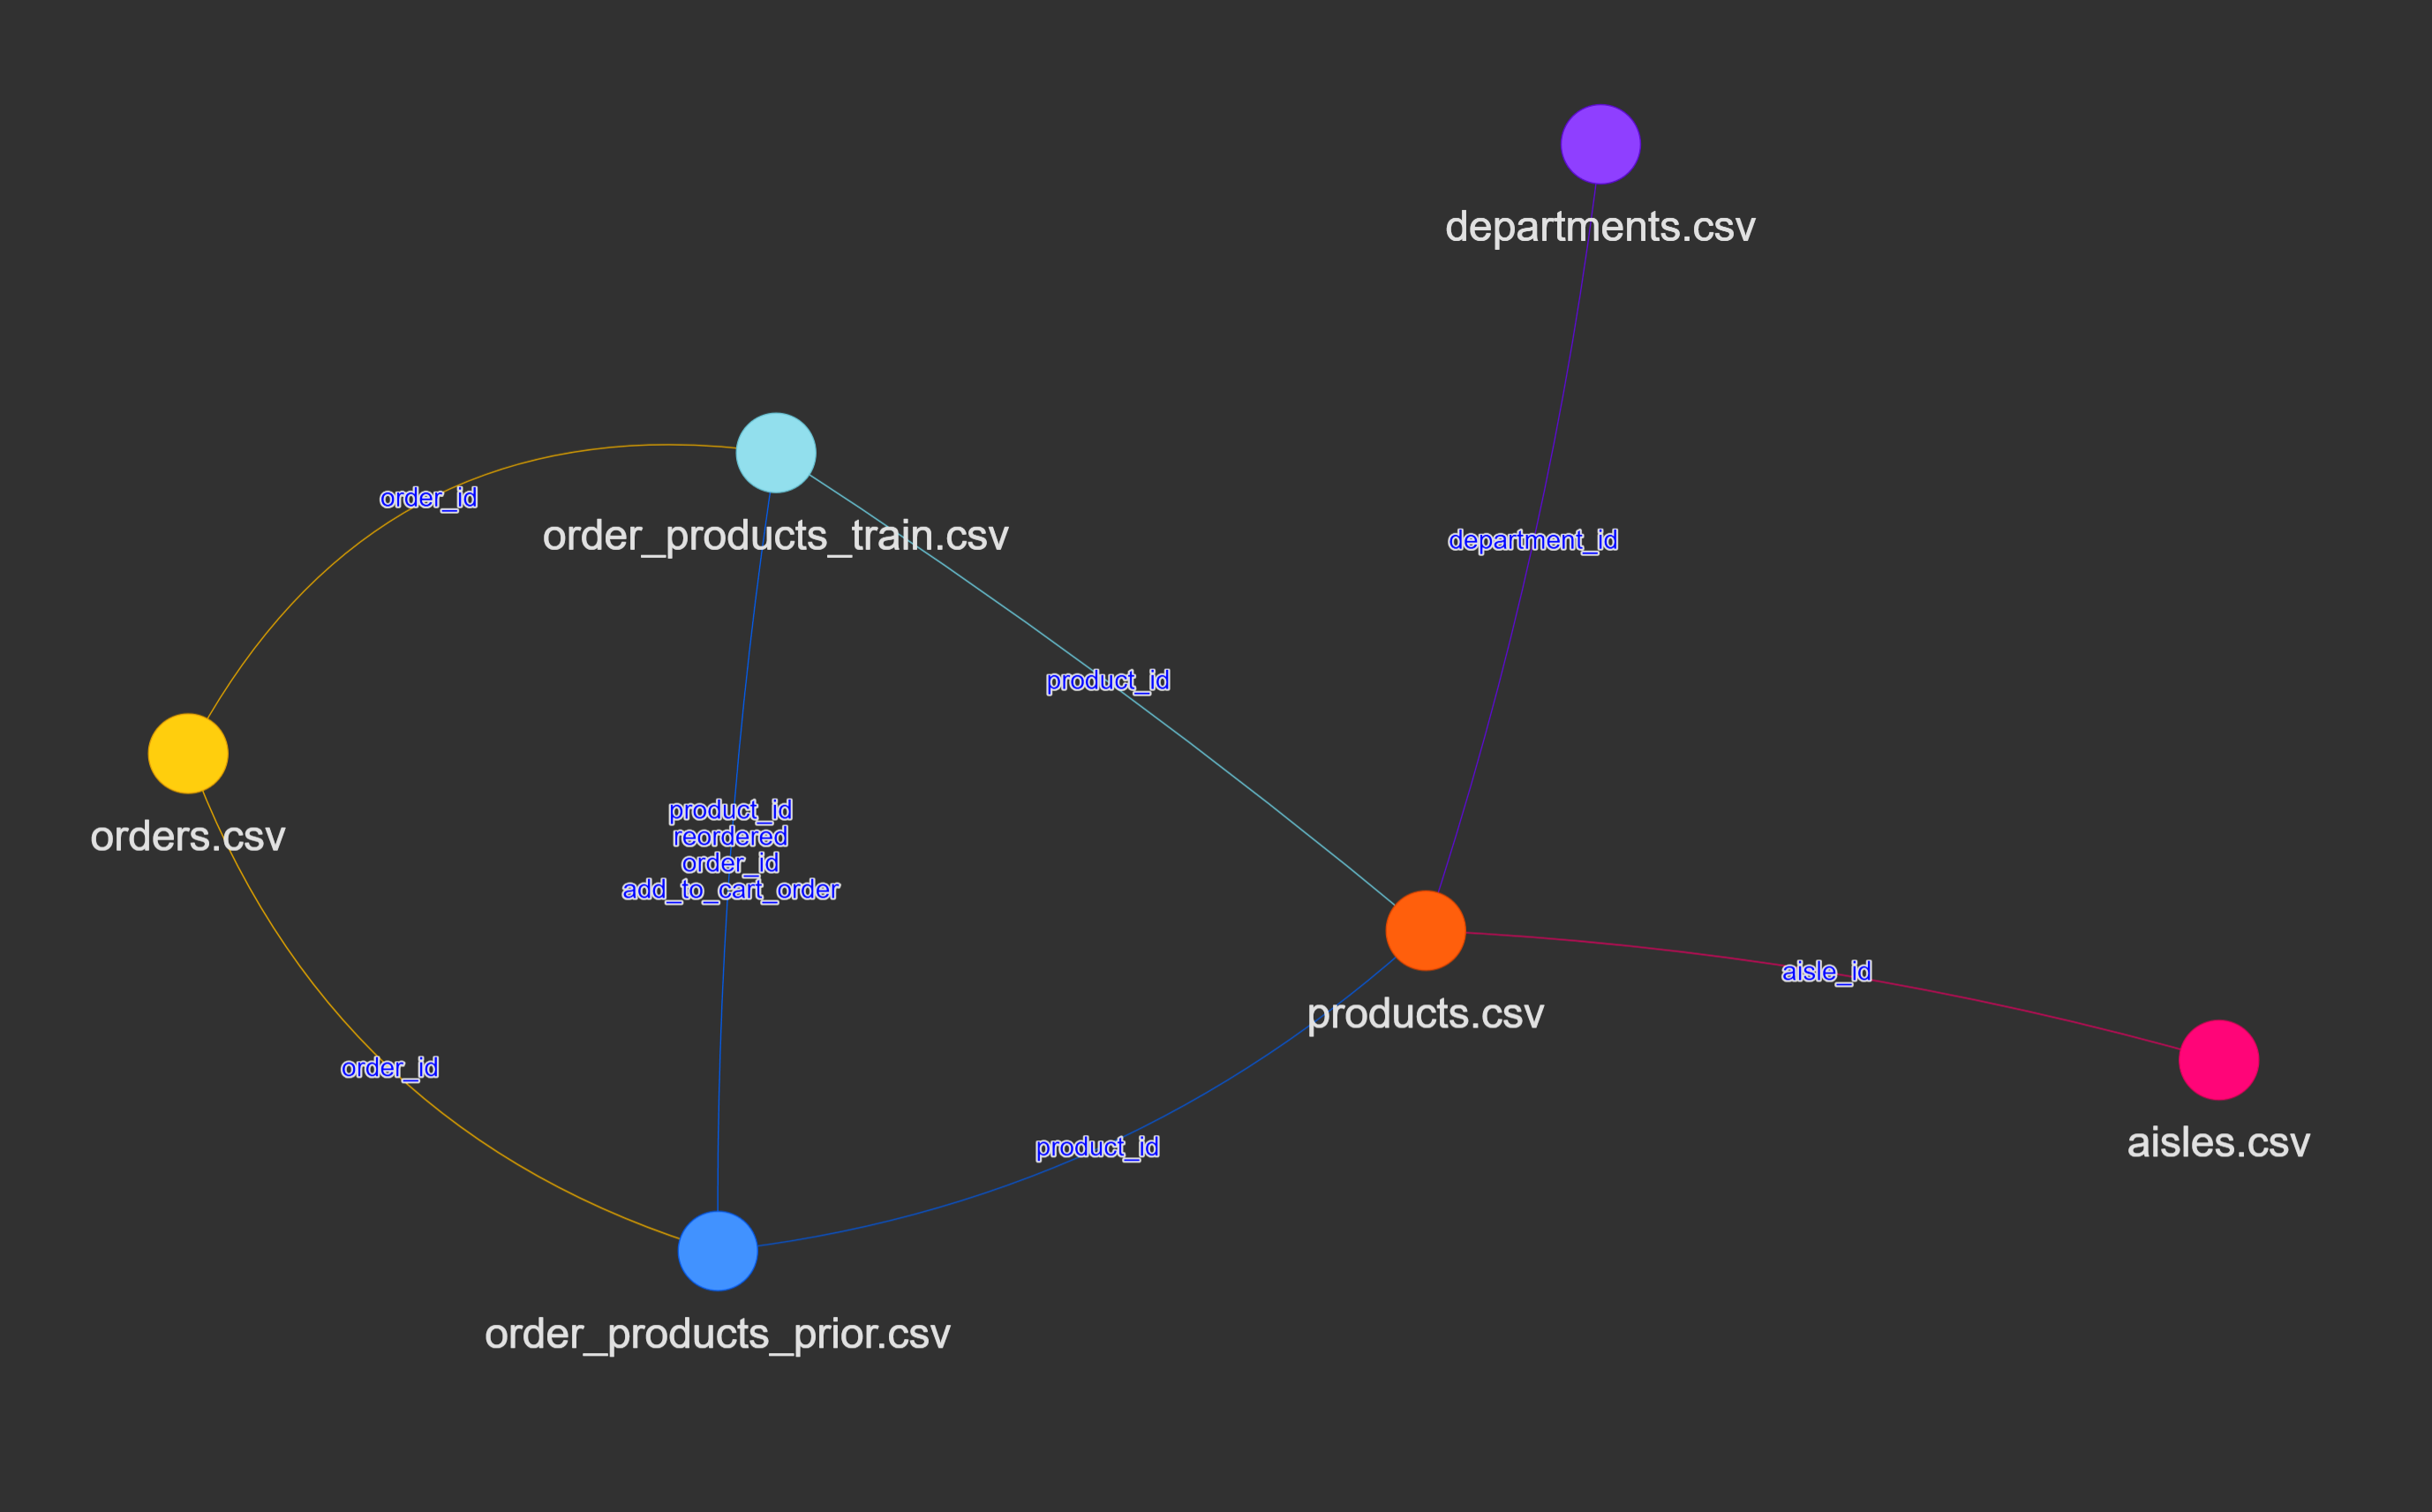

In [5]:
display(Image("csv_relationships.png", width = 1500))

## Exploratory Data Analysis
The `orders.csv` file is particularly interesting, so let’s take a closer look to better understand what it contains.  

We’ll load the file and display a few rows to get a sense of the structure and data.

In [6]:
orders = pd.read_csv(folder_path + '\orders.csv')
display(orders.head(20))

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


I noticed that the `days_since_prior_order` column contains some `NaN` values.  
Let’s check the overall completeness of the dataset by evaluating how many missing values there are in each column.

In [7]:
missing_percentages = orders.isna().mean().sort_values(ascending=False) * 100
missing_df = missing_percentages.reset_index()
missing_df.columns = ['Column', 'Missing (%)']
display(missing_df)

,Column,Missing (%)
0,days_since_prior_order,6.027594
1,user_id,0.000000
2,order_id,0.000000
3,eval_set,0.000000
4,order_number,0.000000
5,order_dow,0.000000
6,order_hour_of_day,0.000000


Only 6.02% of the data is missing in that column. It's likely that the `NaN` values occur when a user places their first order.  

Instead of calculating the correlation between the two columns, we'll directly check this by identifying the rows with `NaN` values in `days_since_prior_order` and evaluating what proportion of those correspond to a user's first order.


In [8]:
sub_frame = orders[orders['days_since_prior_order'].isna()]
total = len(sub_frame)
numerator = len(sub_frame[sub_frame['order_number'] == 1])
proportion = (numerator / total) * 100

print(f"The proportion of missing values in [days_since_prior_order] that occur on a customer's first order is: {proportion:.2f}%")

The proportion of missing values in [days_since_prior_order] that occur on a customer's first order is: 100.00%


This makes sense — for new users, we wouldn’t have any prior time data to compute a difference from.  

From this dataset, we can start exploring a few key behavioral questions:

- **a)** On which days are people placing the most orders?
- **b)** At what times of day are orders being placed most frequently?

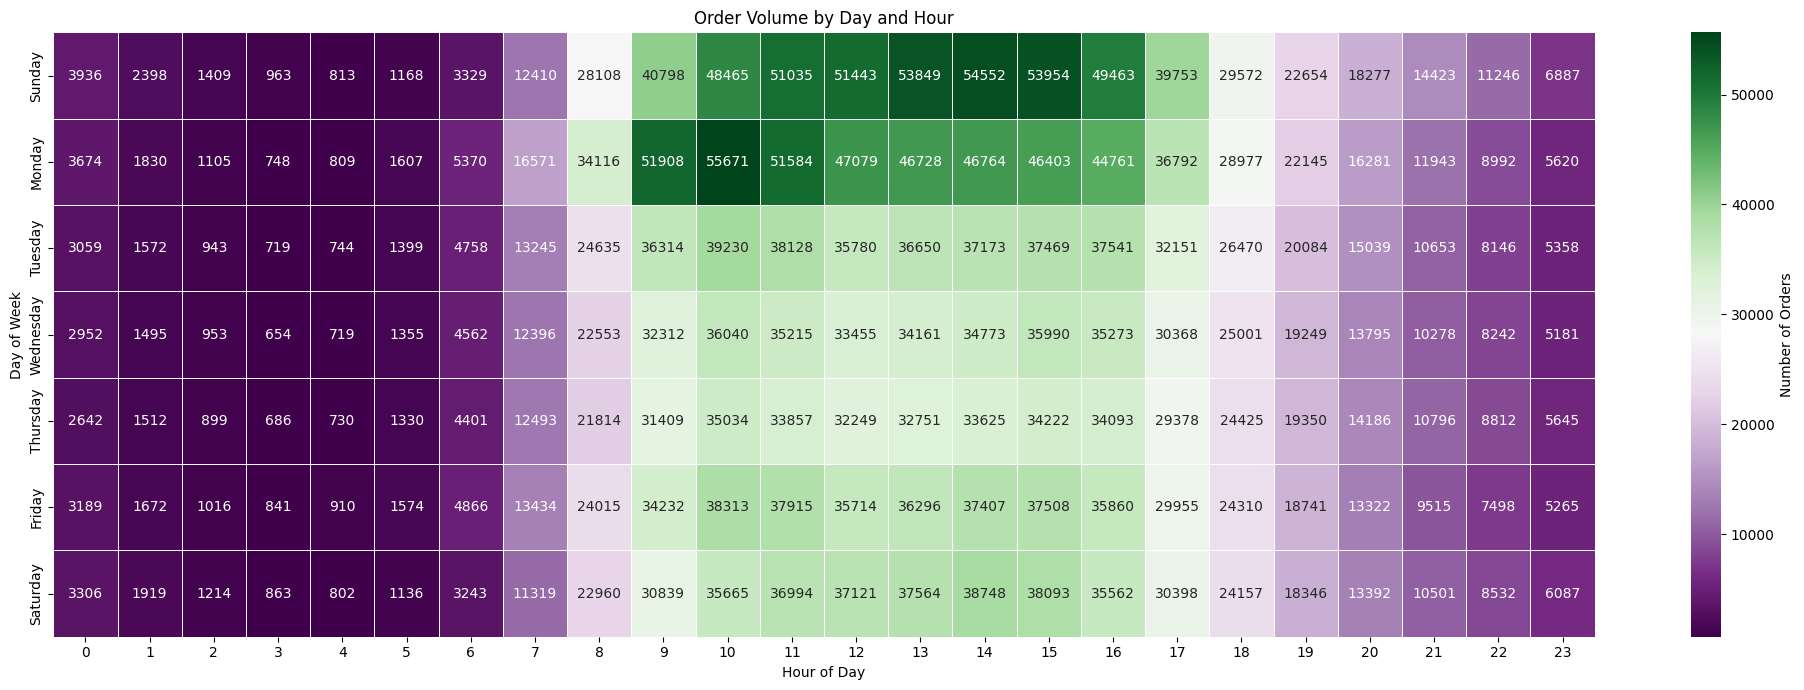

In [9]:
# Map the numeric days of the week to the actual weeday name
day_map = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 
           3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
orders['order_day'] = orders['order_dow'].map(day_map)


# Pivot table
heatmap_data = orders.pivot_table(
    index='order_day',                  # For each day of the week
    columns='order_hour_of_day',        # Breakdown the hours
    values='order_id',                  # Find the orders in that hour
    aggfunc='count'                     # Aggregation method
    )

# Reorder rows to follow chronological week order
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
heatmap_data = heatmap_data.reindex(weekday_order)


# Heatmap
plt.figure(figsize=(20, 7))
sns.heatmap(heatmap_data, cmap = "PRGn", annot = True, fmt = 'd', linewidths = 0.5, cbar_kws={'label': 'Number of Orders'})   # Choose a diverging color scheme to best show high vs low
plt.title("Order Volume by Day and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

It appears that Sunday and Monday are the busiest days for ordering.  

Specifically, there are noticeable spikes on:
- **Sunday afternoons** between **11:00 AM and 3:00 PM**, and  
- **Monday mornings** between **9:00 AM and 11:00 AM**.  

For the rest of the week, user activity is generally highest between **9:00 AM and 5:00 PM**.

While there are still many interesting directions to explore in this dataset, we’ll now shift our focus to the products themselves to better understand which items are most popular among users.

The `order_products__prior.csv` file contains information about which items were ordered, but it lacks product descriptions and department names.  

To get meaningful insights, we’ll need to join this dataset with `products.csv` and `departments.csv`, which contains descriptive information for each product and the mapping between department ID and names respectively.


In [10]:
# Load the needed datasets
product_orders       = pd.read_csv(folder_path + '\order_products_prior.csv')
product_descriptions = pd.read_csv(folder_path + '\products.csv')
departments          = pd.read_csv(folder_path + '\departments.csv')

# Merge product IDs with product names
temp = product_orders.merge(product_descriptions, how = 'left', on  = 'product_id')

# Merge in department names
Full_data = temp.merge(departments, how = 'left', on = 'department_id')

# Display a sample of the header for the merged dataset 
display(Full_data.head(20))

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,produce
2,2,9327,3,0,Garlic Powder,104,13,pantry
3,2,45918,4,1,Coconut Butter,19,13,pantry
4,2,30035,5,0,Natural Sweetener,17,13,pantry
5,2,17794,6,1,Carrots,83,4,produce
6,2,40141,7,1,Original Unflavored Gelatine Mix,105,13,pantry
7,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,pantry
8,2,43668,9,0,Classic Blend Cole Slaw,123,4,produce
9,3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...,120,16,dairy eggs


Now that we’ve combined order details with product descriptions, let’s explore which products are being ordered the most.

We'll start by identifying the top 20 most frequently ordered products across all prior orders.


In [11]:
# Count total number of product orders
total_orders = len(Full_data)

# Get top 20 most frequently ordered products
top_products = Full_data['product_name'].value_counts().head(20)

# Convert to DataFrame for easier manipulation
top_products_df = top_products.reset_index()
top_products_df.columns = ['product_name', 'order_count']

# Add percentage of total orders
top_products_df['percent_of_total_orders'] = (top_products_df['order_count'] / total_orders) * 100

# Merge with department info
product_dept = Full_data[['product_name', 'department']].drop_duplicates()
top_products_df = top_products_df.merge(product_dept, on='product_name', how='left')

# Display final result
display(top_products_df)

,product_name,order_count,percent_of_total_orders,department
0,Banana,472565,1.456983,produce
1,Bag of Organic Bananas,379450,1.169897,produce
2,Organic Strawberries,264683,0.816054,produce
3,Organic Baby Spinach,241921,0.745876,produce
4,Organic Hass Avocado,213584,0.658509,produce
5,Organic Avocado,176815,0.545145,produce
6,Large Lemon,152657,0.470663,produce
7,Strawberries,142951,0.440738,produce
8,Limes,140627,0.433572,produce
9,Organic Whole Milk,137905,0.425180,dairy eggs


This is interesting — many of the top 20 best-selling items come from the produce section.

Let's take a look at the items that are the most frequently reordered before moving on, we will also remove the produce and dairy eggs department to try and see more interesting products being reordered:

In [12]:
# Define departments to exclude from the analysis
excluded_departments = ['produce', 'dairy eggs']

# Only consider reordered items
reordered_items = Full_data[(Full_data['reordered'] == 1) & (~Full_data['department'].str.lower().isin(excluded_departments))]

# Count the number of times each product was reordered
reordered_counts = reordered_items['product_name'].value_counts().reset_index()
reordered_counts.columns = ['product_name', 'reorder_count']

# Merge department info for context
reordered_counts = reordered_counts.merge(
    Full_data[['product_name', 'department']].drop_duplicates(),
    on='product_name',
    how='left'
)

# Display top 20 reordered items
display(reordered_counts.head(20))

,product_name,reorder_count,department
0,Sparkling Water Grapefruit,58513,beverages
1,Original Hummus,51690,deli
2,Spring Water,45558,beverages
3,100% Whole Wheat Bread,44834,bakery
4,Lime Sparkling Water,34538,beverages
5,Boneless Skinless Chicken Breasts,33286,meat seafood
6,Blueberries,32592,frozen
7,Sparkling Natural Mineral Water,31500,beverages
8,100% Raw Coconut Water,29939,beverages
9,Soda,27791,beverages



Let’s take a closer look at how the top products are distributed across departments, along with the percentage each contributes to the total number of orders.

In [19]:
# Aggregate data
top_products = Full_data.groupby(['department', 'product_name']).agg(
    total_orders=('order_id', 'count')
).reset_index()

# Filter out low-selling items
top_products = top_products[top_products['total_orders'] > 20000]

# Normalize across departments to prevent Produce from dominating
top_products['log_orders'] = top_products['total_orders'].apply(lambda x: max(1, x)).apply(np.log)

# Choose a color map
custom_colors = px.colors.qualitative.Dark24 

# Plot Treemap
fig = px.treemap(
    top_products,
    path=['department', 'product_name'],
    values='log_orders',
    color='department',
    title='Best-Selling Products by Department (Log Scaled)',
    width=2000,
    height=1000
)

fig.update_layout(showlegend=False)
fig.show()

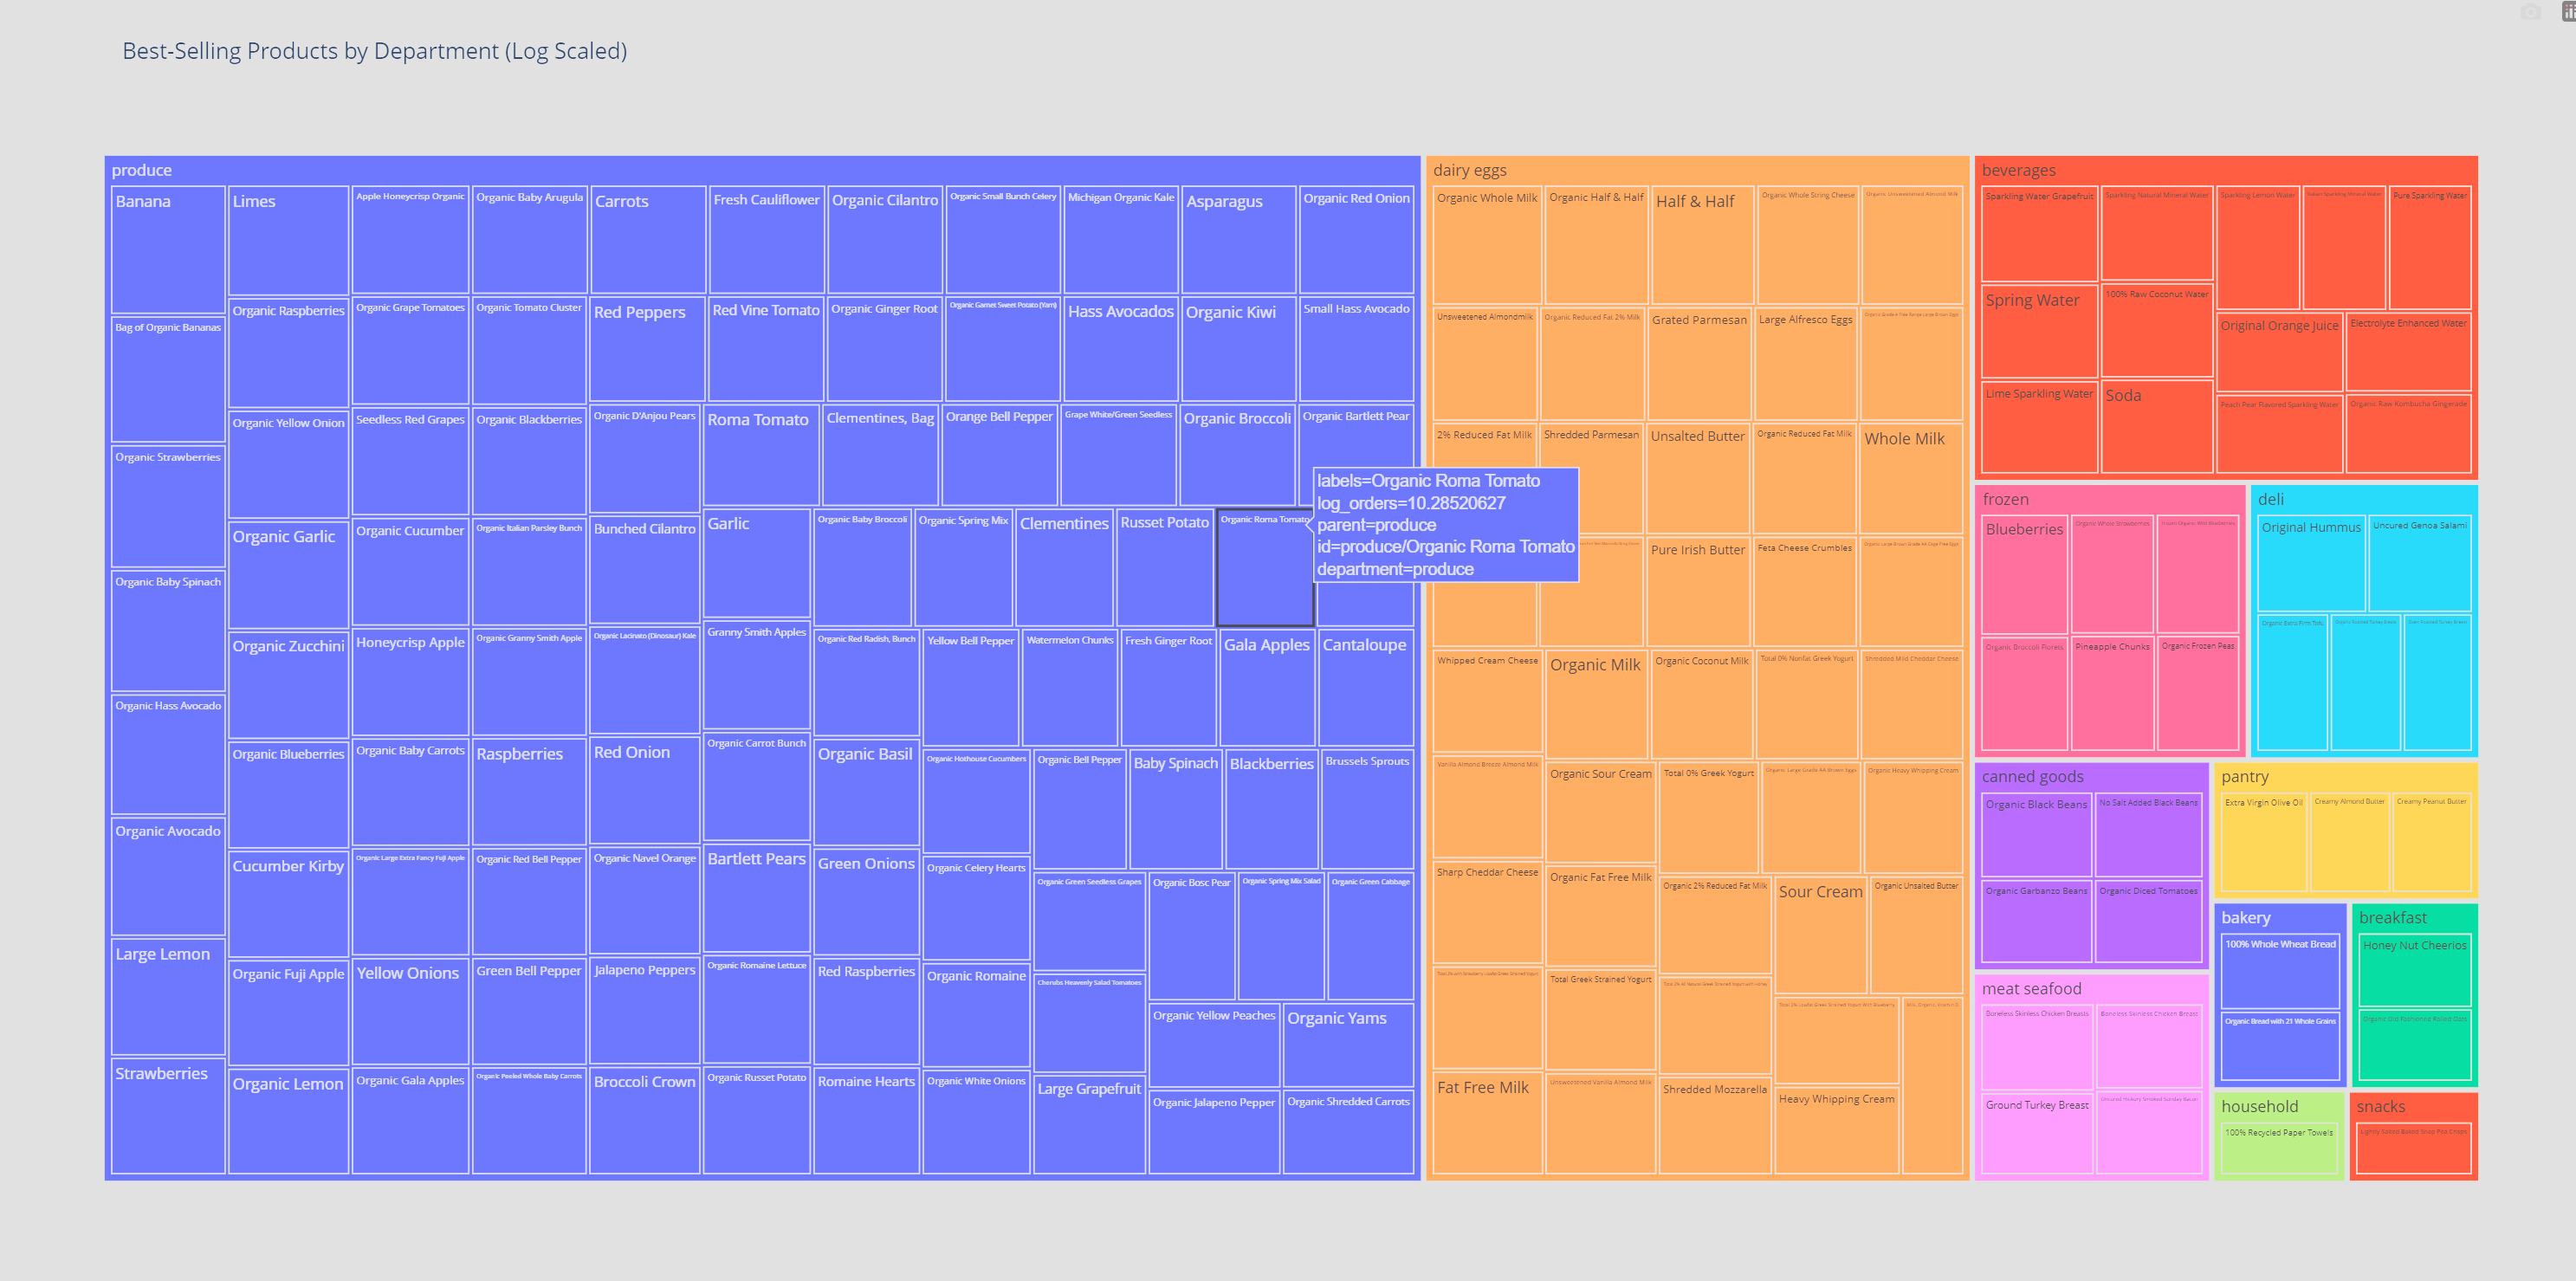

In [22]:
display(Image("topsellingAll.png", width = 1500))

To better visualize how top-selling products are distributed across departments, we’ve created a treemap.

We’ve:
- Aggregated product counts by department,
- Filtered out low-selling products to focus on high-impact items,
- Applied a log scale to prevent large departments (like Produce) from visually overwhelming the rest.

This gives us a clearer, more balanced view of the most frequently ordered products across the catalog.

This treemap is useful because it highlights how the **Produce** department contains many high-selling items. In contrast, departments like **Household** or **Snacks** only have one or two products that reach a similar volume.

However, this view is skewed by the fact that some departments naturally sell in higher volumes than others. To get a more balanced view, we should normalize the data by limiting the number of top items shown per department. This will help us identify the best-selling products *within* each department, rather than just across the whole catalog.


In [20]:
# Aggregate data
top_products = Full_data.groupby(['department', 'product_name']).agg(
    total_orders=('order_id', 'count')
).reset_index()

# Sort and get top 10 per department
top_10_per_dept = top_products.sort_values(['department', 'total_orders'], ascending=[True, False])\
                              .groupby('department').head(10)

# Normalize for visualization
top_10_per_dept['log_orders'] = top_10_per_dept['total_orders'].apply(lambda x: max(1, x)).apply(np.log)

# Cut down some of the more wordier product descriptions
top_10_per_dept['short_name'] = top_10_per_dept['product_name'].apply(lambda x: x if len(x) <= 25 else x[:25] + '...')


# Plot Treemap
fig = px.treemap(
    top_10_per_dept,
    path=['department', 'short_name'],
    values='log_orders',
    color='department',
    title='Top 10 Best-Selling Products by Department (Log Scaled)',
    width=2000,
    height=1000,
    color_discrete_sequence=px.colors.qualitative.Dark24
)

fig.update_layout(showlegend=False)
fig.show()

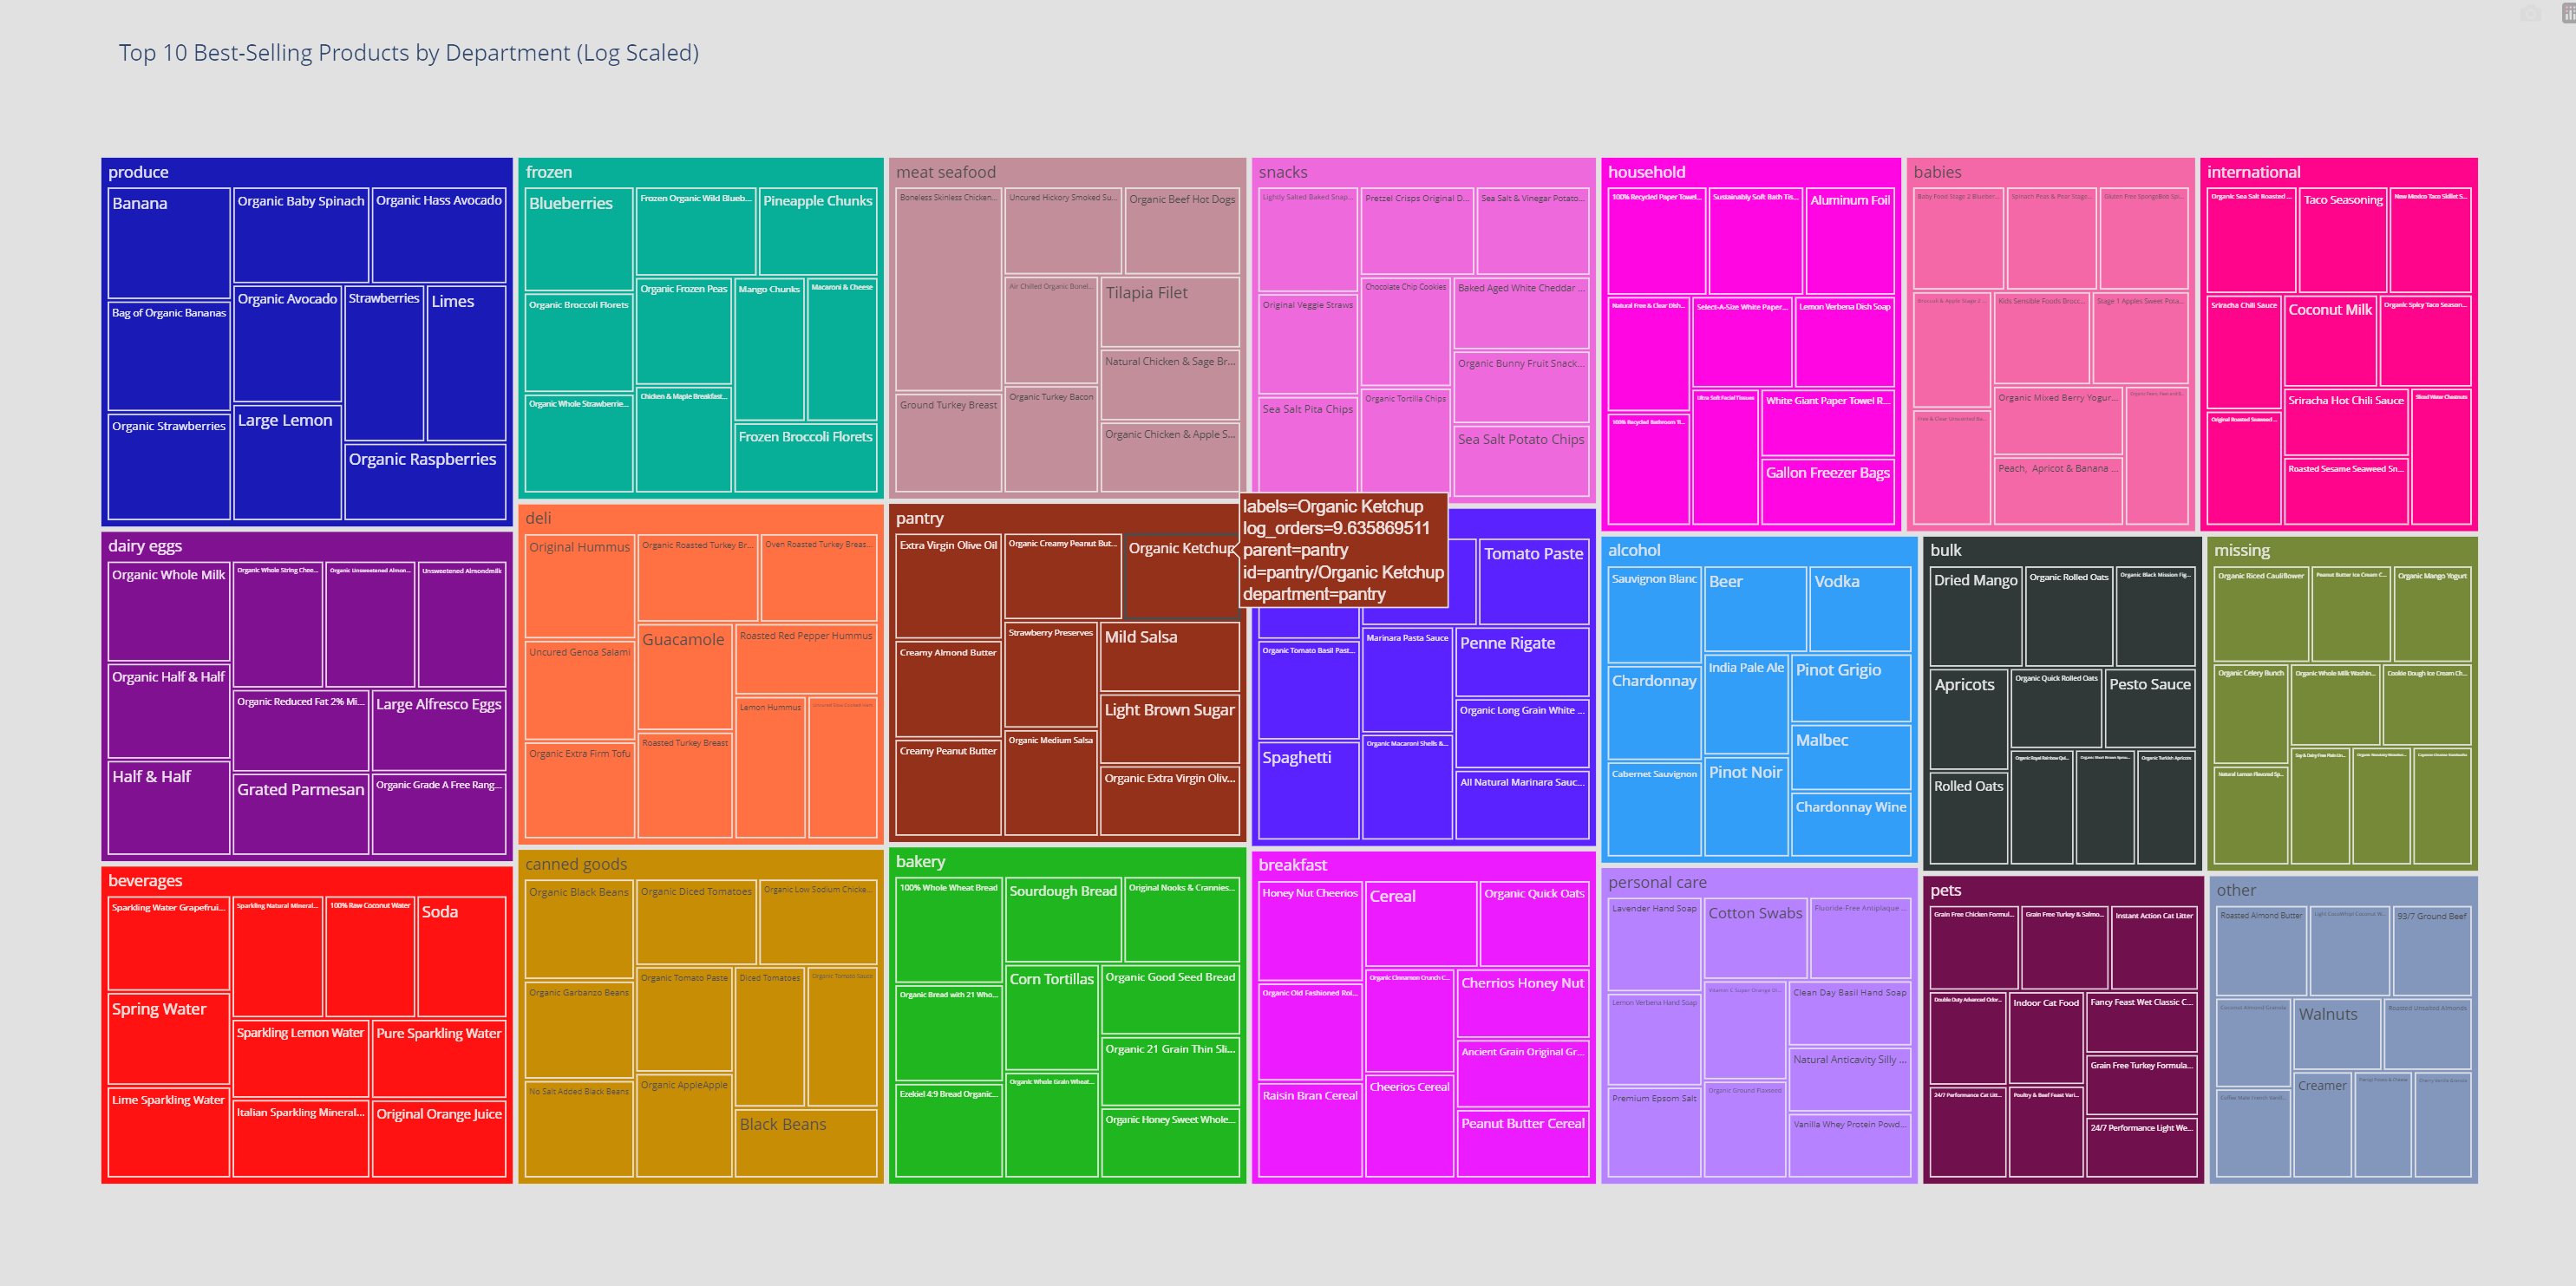

In [23]:
display(Image("topsellingNormalized.png", width = 1500))

This view is more balanced and informative. Departments that didn’t have high-volume items in the earlier treemap are now represented, giving us a clearer picture of their best-selling products.

We also notice that some items appear without an associated department — this suggests there may be missing or inconsistent data in the `products.csv` or `departments.csv` files.


## Advanced Analysis

Next, we’ll move into more advanced analysis by performing **basket analysis**.  
This will help us understand which items are most frequently purchased together — valuable insight for recommendations, promotions, or in-store placement.


In [15]:
# Count all product frequencies
product_counts = Full_data['product_name'].value_counts()

# Select top N remaining products
mid_products = product_counts.iloc[0:100].index

# Filter original dataset
df_filtered = Full_data[Full_data['product_name'].isin(mid_products)]

# Create list of product lists per order
grouped = df_filtered.groupby('order_id')['product_name'].apply(list)

# Remove single-item orders (not useful for basket analysis)
grouped = grouped[grouped.apply(len) > 1]

To identify commonly paired products, we apply **market basket analysis** using the **Apriori algorithm**.

Here’s a breakdown of what happens in this step:

1. **Transaction Encoding**:  
   We convert our list of product baskets (each representing a single order) into a binary matrix using `TransactionEncoder`, where each column is a product and each row indicates its presence (`True`/`False`) in that order. For example, for three orders that had 
   
   $$ \textbf{Order 1} = \{\text{Milk}, \text{Bread}\} $$
   $$ \textbf{Order 2} = \{\text{Milk}, \text{Apples}, \text{Soda}, \text{Eggs}\} $$
   $$ \textbf{Order 3} = \{\text{Milk}, \text{Bread}, \text{Apples}, \text{Soda}\} $$
   
   we could create the binary matrix:

$$
\begin{array}{l|ccccc}
\textbf{Order ID} & \text{Milk} & \text{Bread} & \text{Apples} & \text{Soda} & \text{Eggs} \\
\hline
1 & 1 & 1 & 0 & 0 & 0 \\
2 & 1 & 0 & 1 & 1 & 1 \\
3 & 1 & 1 & 1 & 1 & 0 \\
\end{array}
$$



2. **Frequent Itemset Generation**:  
   We apply the `apriori` algorithm to discover combinations of products (itemsets) that appear together in at least 1% of all baskets. We limit itemsets to length 2 to focus on pairs of products.

3. **Association Rule Mining**:  
   Using `association_rules`, we extract rules from the frequent itemsets that meet a minimum confidence threshold of 10%.  
   - **Confidence** measures how often items in the consequent appear in orders that contain the antecedent.  
   - We also eliminate duplicate rules using a custom frozen set to avoid symmetric pairs (e.g., A→B and B→A).

This process allows us to uncover product relationships that could inform recommendations, promotions, or store layout decisions.


In [16]:
# Encode using TransactionEncoder
te = TransactionEncoder()
te_result = te.fit_transform(grouped.tolist())
df_encoded = pd.DataFrame(te_result, columns = te.columns_)

# Run apriori
frequent_itemsets = apriori(df_encoded, min_support = 0.01, use_colnames = True, max_len = 2)

# Association rules
rules = association_rules(frequent_itemsets, metric = "confidence", min_threshold = 0.10)
rules['rule_set'] = rules.apply(lambda row: frozenset(row['antecedents'] | row['consequents']), axis = 1)
rules = rules.drop_duplicates(subset='rule_set')

Now that we’ve generated our association rules, let’s take a look at the most important metrics:

- **Antecedents**: The items that appear first in the rule.
- **Consequents**: The items that tend to follow.
- **Support**: The proportion of transactions that contain both the antecedent and consequent.
- **Confidence**: The conditional probability that the consequent appears given the antecedent.
- **Lift**: How much more likely the consequent is to occur with the antecedent than by random chance. A lift > 1 indicates a positive association.

These metrics help us evaluate the strength and usefulness of each rule.


In [17]:
# Print out the most important columns of the rules
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

,antecedents,consequents,support,confidence,lift
0,(Apple Honeycrisp Organic),(Bag of Organic Bananas),0.014286,0.294671,1.492675
1,(Apple Honeycrisp Organic),(Banana),0.010510,0.216775,0.895739
2,(Large Lemon),(Bag of Organic Bananas),0.011700,0.136555,0.691725
3,(Limes),(Bag of Organic Bananas),0.012589,0.157619,0.798426
4,(Organic Avocado),(Bag of Organic Bananas),0.013801,0.139056,0.704397
...,...,...,...,...,...
86,(Organic Hass Avocado),(Organic Strawberries),0.024595,0.204407,1.389674
88,(Organic Yellow Onion),(Organic Hass Avocado),0.012014,0.184918,1.536870
89,(Organic Raspberries),(Organic Strawberries),0.020416,0.264994,1.801572
91,(Organic Whole Milk),(Organic Strawberries),0.014357,0.193715,1.316981


As we worked through the association rules, a few key observations emerged:

- **Redundant associations** need to be pruned. For example, if item A is strongly associated with item B, then item B will also be strongly associated with item A. To avoid showing both directions of the same relationship, we used `rules.apply()` with a `frozenset` to filter out duplicates.

From the final set of rules, we found several meaningful product relationships:

- If someone buys <span style="color:#f4a261"><strong>🍌 bananas</strong></span>, they are <strong>41% more likely</strong> to also buy <span style="color:#e76f51"><strong>🍎 apples</strong></span> — this pairing is <strong>1.70×</strong> more likely than random chance.

- If someone buys <span style="color:#2a9d8f"><strong>🍋 lemons</strong></span>, they are <strong>21% more likely</strong> to also buy <span style="color:#32CD32"><strong>🍋‍🟩 limes</strong></span> — a <strong>2.41× lift</strong>.

- If someone buys <span style="color:#32CD32"><strong>🍋‍🟩 limes</strong></span>, they are <strong>13% more likely</strong> to also buy <span style="color:#8ecae6"><strong>🌿 cilantro</strong></span>, with a <strong>3.32× lift</strong>, making this one of the strongest associations.

These insights can inform <strong>cross-promotions</strong>, <strong>in-store product placement</strong>, or <strong>personalized recommendations</strong> in a retail setting.



_________________________________

## Task E: Product Bundle Optimizer — Client-Facing Application Design

To translate our data analysis into direct business value, we propose a client-facing application called the **Product Bundle Optimizer**.

### 🎯 Client: Grocery Store Marketing or Operations Team

**Objective**:  
Use real purchase behavior to identify products that are frequently bought together, and turn them into **physical bundles** customers can buy in-store or online.

For example:
> If the system detects a strong association between **spaghetti noodles** and **tomato sauce**, it could suggest a "Noodle Night Bundle" to be stocked as a ready-to-go combo.

This helps:
- Increase basket size
- Improve convenience for shoppers
- Reduce decision fatigue
- Boost sales of slower-moving items by bundling them with best-sellers

---

### 🧠 Features:

- **Association Rule Engine**: Uses Apriori algorithm to discover high-lift, high-confidence product pairings from historical orders.
- **Bundle Explorer**: A dashboard where marketing teams can:
  - View top item pairs by department
  - Filter by support/lift/confidence
  - Generate bundle ideas per season or campaign
- **Bundle Suggestions**: Highlight specific bundle types like:
  - Meal kits (e.g., "Taco Night")
  - Complementary items (e.g., "Coffee & Creamer")
  - Add-on triggers (e.g., "Buy cereal → Recommend milk")

---

### 🛠️ Technical Stack:

| Layer        | Technology |
|--------------|------------|
| Backend      | Python + FastAPI |
| ML Engine    | Apriori (mlxtend), Pandas |
| Frontend     | Streamlit or Dash for rapid UI development |
| Database     | PostgreSQL (or BigQuery for scalability) |
| Deployment   | Docker, AWS EC2 or GCP App Engine |

---

### 📈 Example Output:

| Antecedent            | Consequent          | Confidence | Lift  |
|-----------------------|---------------------|------------|-------|
| Spaghetti Noodles 🍝   | Tomato Sauce 🍅       | 42%        | 2.13  |
| Tortillas 🌮           | Shredded Cheese 🧀     | 31%        | 1.87  |
| Avocados 🥑           | Cilantro 🌿            | 27%        | 2.56  |

These bundles could be physically packaged together in stores, featured on the homepage, or offered with a small discount to drive sales.

---

This type of application directly connects data insights with real-world actions, turning complex purchase behavior into something a marketing or retail operations team can easily act on.


### ⚙️ Future Considerations: Scaling Beyond Apriori

While the Apriori algorithm is well-suited for small to medium-sized datasets, it can become computationally expensive as the number of items or transactions grows. This is because it generates and evaluates a large number of candidate itemsets — particularly problematic when item diversity is high.

#### Potential Alternatives:
- **FP-Growth**: A more efficient frequent pattern mining algorithm that avoids generating all candidate itemsets and instead builds a prefix tree (FP-tree). It's much faster for large datasets and is available via `mlxtend` or Spark MLlib.
- **Spark MLlib (Distributed Association Rules)**: If the data grows significantly (e.g., millions of users/orders), running the analysis on a distributed system like Apache Spark allows you to scale horizontally and handle much larger workloads.
- **Neural Embedding-Based Approaches**: For very large datasets or more nuanced recommendations, product embeddings (e.g., using Word2Vec or matrix factorization) can capture complex item-to-item relationships beyond strict co-occurrence.

In a real production system, we would likely begin with Apriori for prototyping and insights, then graduate to FP-Growth or a scalable recommender system once the data volume or latency requirements increase.


### 🚀 Alternative: FP-Growth for Scalable Pattern Mining

To scale the Product Bundle Optimizer for larger datasets or real-time recommendation use cases, we could replace the Apriori algorithm with **FP-Growth** (Frequent Pattern Growth).

Unlike Apriori, which generates and tests a large number of candidate itemsets, FP-Growth constructs a **compact tree (FP-tree)** that represents the transactions, allowing frequent itemsets to be mined more efficiently.

This approach significantly reduces runtime on large datasets while maintaining comparable accuracy.

---

### 🔁 Quick Comparison

| Algorithm   | Speed | Memory | Scalability | Best Use Case |
|-------------|-------|--------|-------------|----------------|
| Apriori     | Slow  | Low    | Poor        | Prototyping or small datasets |
| FP-Growth   | Fast  | Medium | Good        | Large itemsets or real-time dashboards |
| Spark MLlib | Fast  | High   | Excellent   | Distributed, enterprise-scale workloads |

---

### 🧪 Prototype (mlxtend FP-Growth)

```python
from mlxtend.frequent_patterns import fpgrowth

# Same encoding as before
te = TransactionEncoder()
te_result = te.fit_transform(grouped.tolist())
df_encoded = pd.DataFrame(te_result, columns=te.columns_)

# Apply FP-Growth instead of Apriori
frequent_itemsets_fp = fpgrowth(df_encoded, min_support=0.01, use_colnames=True, max_len=2)

# Generate association rules
rules_fp = association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=0.10)
rules_fp['rule_set'] = rules_fp.apply(lambda row: frozenset(row['antecedents'] | row['consequents']), axis=1)
rules_fp = rules_fp.drop_duplicates(subset='rule_set')

# Display
display(rules_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


## 📌 Conclusion

This notebook explored the Instacart dataset through multiple stages of analysis, culminating in actionable insights and a client-facing application concept.

### 🔍 Key Takeaways:
- **Customer Behavior**:
  - Most orders occur on **Sunday and Monday**.
  - A small but meaningful portion of the data had missing time information — which was tied to **first-time orders**, validating its structure.

- **Product Trends**:
  - The **Produce** department dominates high-volume sales, but when normalized, every department has its own set of strong performers.
  - Popular items like **bananas, apples, limes, and cilantro** frequently co-occur in customer baskets.

- **Association Rules**:
  - We applied the **Apriori algorithm** to uncover product pairings that customers frequently buy together.
  - High-lift combinations suggest strong opportunities for **cross-promotion** or **bundled offerings**.

- **Proposed Solution**:
  - Designed the **Product Bundle Optimizer**, an application concept for store operators or marketing teams to generate ready-to-go product bundles based on real customer behavior.
  - Outlined a scalable tech stack and suggested alternatives like **FP-Growth** for future optimization.

### ✅ Final Thoughts:
This analysis was fun to do and I'm happy that I got the chance to look into it. Thank you for your time and I hope to hear from you soon.

Thank you,

Dr. John Montalbo
